In [1]:
import os 
from random import randint
from datetime import datetime
from pyvi import ViTokenizer
from gensim import corpora, matutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import pickle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, svm
from sklearn.model_selection import GridSearchCV, KFold
import gensim
import gensim.downloader as gensim_api

from file_loader import FileStore, FileReader, DataLoader
from preprocessing import *
import const

# Preprocessing

In [2]:
dataLoader = DataLoader(const.DATA_PATH)
data = dataLoader.get_json()

fileReader = FileReader('./data/vietnamese-stopwords.txt')
stopwordLst = fileReader.read_stopwords()

In [3]:
len(data)

33759

In [4]:
data[0]

{'category': 'Chinh tri Xa hoi',
 'content': '\ufeff Thành lập dự án POLICY phòng chống HIV/AIDS ở VN (NLĐ)- Quỹ hỗ trợ khẩn cấp về AIDS của Hoa Kỳ vừa thành lập dự án POLICY tại VN với cam kết hỗ trợ Chính phủ và nhân dân VN đối phó HIV/AIDS.Dự án có nhiệm vụ chính là cải thiện công tác phòng chống HIV/AIDS thông qua các lĩnh vực xây dựng chính sách, rà soát các văn bản pháp luật, xây dựng chiến lược quảng bá, xây dựng chương trình đào tạo về phòng chống HIV/AIDS, lên kế hoạch bố trí nguồn lực, huấn luyện và nghiên cứu về phương tiện truyền thông đại chúng, tổ chức các hoạt động nhằm giảm kỳ thị và phân biệt đối xử đối với người có HIV/AIDS... Theo TTXVN, dự án POLICY đặc biệt quan tâm đến công tác truyền thông phòng chống HIV/AIDS, coi đây là một biện pháp tích cực và hữu hiệu trong việc phòng chống có hiệu quả HIV/AIDS. Thời gian tới, dự án POLICY sẽ tiếp tục tổ chức các hoạt động nhằm nâng cao nhận thức cho những người có trách nhiệm với công tác chỉ đạo phòng chống HIV/AIDS.\n\n'}

In [5]:
processing(data[0]['content'], stopwordLst)

'thành_lập dự_án policy phòng_chống hivaids vn nlđ quỹ khẩn_cấp aids hoa kỳ thành_lập dự_án policy vn cam_kết chính_phủ nhân_dân vn đối_phó_hivaids dự_án nhiệm_vụ cải_thiện công_tác phòng_chống hivaids thông_qua lĩnh_vực xây_dựng chính_sách rà_soát văn_bản pháp_luật xây_dựng chiến_lược quảng_bá xây_dựng chương_trình đào_tạo phòng_chống hivaids kế_hoạch bố_trí nguồn_lực huấn_luyện nghiên_cứu phương_tiện truyền_thông đại_chúng tổ_chức hoạt_động kỳ_thị phân_biệt đối_xử hivaids ttxvn dự_án policy công_tác truyền_thông phòng_chống hivaids coi biện_pháp tích_cực hữu_hiệu phòng_chống hiệu_quả hivaids dự_án policy tổ_chức hoạt_động nâng nhận_thức trách_nhiệm công_tác chỉ_đạo phòng_chống hivaids'

In [6]:
features = []
labels = []

In [7]:
for d in data:
    features.append(d['content'])
    labels.append(d['category'])

In [8]:
label_dict = dict(
                    zip(
                        sorted(set(labels), key=labels.index), 
                        range(len(labels))
                        )
                )

In [9]:
label_dict

{'Chinh tri Xa hoi': 0,
 'Doi song': 1,
 'Khoa hoc': 2,
 'Kinh doanh': 3,
 'Phap luat': 4,
 'Suc khoe': 5,
 'The gioi': 6,
 'The thao': 7,
 'Van hoa': 8,
 'Vi tinh': 9}

In [10]:
label_indices = [label_dict[label] for label in labels]

In [11]:
features = [processing(article, stopwordLst) for article in features]

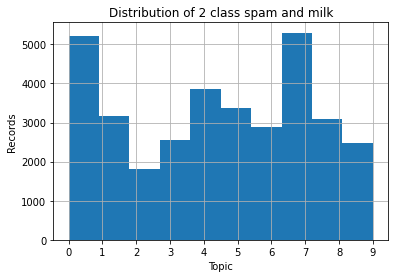

In [12]:
label_series = pd.Series(label_indices)

label_series.hist(bins=10)
plt.xticks(range(10))

plt.ylabel('Records')
plt.xlabel('Topic')
plt.title('Distribution of 2 class spam and milk')
plt.show()

# Feature extraction

In [13]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    features, label_indices, 
    test_size=test_ratio,
    stratify=label_indices
)

## BOW

In [14]:
def get_BoW_feature_extractor(max_feature_dim=5000, ngram_range=(1,2)):
    
    bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=max_feature_dim, ngram_range=ngram_range)
    return bow_vectorizer

In [15]:
# Extract BoW features
bow_extractor_5000_1gram = get_BoW_feature_extractor(max_feature_dim=5000, ngram_range=(1,1))
bow_feature_train_5000_1gram = bow_extractor_5000_1gram.fit_transform(x_train)

bow_extractor_5000_2gram = get_BoW_feature_extractor(max_feature_dim=5000, ngram_range=(1,2))
bow_feature_train_5000_2gram = bow_extractor_5000_2gram.fit_transform(x_train)

bow_extractor_5000_3gram = get_BoW_feature_extractor(max_feature_dim=5000, ngram_range=(1,3))
bow_feature_train_5000_3gram = bow_extractor_5000_3gram.fit_transform(x_train)

# TF - IDF

In [28]:
def get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,2)):
    
    tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=ngram_range)
    
    return tfidf_vectorizer

In [29]:
# Extract TFIDF features
tfidf_extractor_1gram = get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,1))
tfidf_feature_train_1gram = tfidf_extractor_1gram.fit_transform(x_train)

tfidf_extractor_2gram = get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,2))
tfidf_feature_train_2gram = tfidf_extractor_2gram.fit_transform(x_train)

tfidf_extractor_3gram = get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,3))
tfidf_feature_train_3gram = tfidf_extractor_3gram.fit_transform(x_train)


# Model

In [20]:
# This function is to plot the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
def optimize_model_parameter(model, X_train, Y_train):
    '''
    Perform hyper parameter tuning for model
    '''
    best_model = model.fit(X_train, Y_train)
    #print(svm_grid_model.best_estimator_) 
    
    # Estimate the best accuracy
    train_accuracy = best_model.best_score_ *100
    print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )
    return best_model

def evaluate_model(model, X_test, Y_test):
    '''
    Initial evaluate model on test set
    '''
    # Predict topic indices in x_test
    y_test_hat = model.predict(x_test)

    # Estimate the testing accuracy
    test_accuracy = metrics.accuracy_score(y_test,y_test_hat)*100
    print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
    return test_accuracy

## SVM 

In [17]:
def get_SVM_model():
    '''
    Get linear SVM model and list of parameters
    '''
    # Initialize SVM model as a classifier
    svm_model = svm.SVC(probability=True) 

    # Define config for params
    param_grid = {'C': [ 100, 200], 
                  'kernel': ['linear', 'rbf']} 

    # Perform Grid search
    grid = GridSearchCV(
        svm_model, 
        param_grid, 
        refit = True, 
        verbose = 3, 
        cv=5,
        n_jobs=-1
    )
    
    return grid

### BoW 

In [18]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, bow_feature_train_5000_1gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", bow_extractor_5000_1gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy for our training dataset with tuning is : 89.28%
Accuracy for our testing dataset with tuning is : 88.76%


88.75888625592417

In [21]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)
plot_confusion_matrix(confus_mat, title='Confusion matrix', target_names=sorted(set(label_dict), key=label_dict.index))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1044
           1       0.84      0.84      0.84       632
           2       0.82      0.78      0.80       364
           3       0.88      0.86      0.87       510
           4       0.92      0.90      0.91       774
           5       0.89      0.91      0.90       677
           6       0.91      0.90      0.91       579
           7       0.98      0.97      0.98      1060
           8       0.93      0.90      0.91       616
           9       0.92      0.89      0.91       496

    accuracy                           0.89      6752
   macro avg       0.89      0.88      0.88      6752
weighted avg       0.89      0.89      0.89      6752



AttributeError: 'dict' object has no attribute 'index'

In [22]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, bow_feature_train_5000_2gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", bow_extractor_5000_2gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy for our training dataset with tuning is : 89.18%
Accuracy for our testing dataset with tuning is : 88.77%


88.77369668246445

In [25]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)
confus_mat

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1044
           1       0.84      0.84      0.84       632
           2       0.80      0.78      0.79       364
           3       0.88      0.86      0.87       510
           4       0.91      0.90      0.91       774
           5       0.88      0.91      0.89       677
           6       0.91      0.90      0.90       579
           7       0.98      0.97      0.98      1060
           8       0.93      0.90      0.91       616
           9       0.93      0.90      0.92       496

    accuracy                           0.89      6752
   macro avg       0.89      0.88      0.88      6752
weighted avg       0.89      0.89      0.89      6752



array([[ 875,   30,    7,   27,   44,   24,   12,    3,   16,    6],
       [  43,  532,   13,    4,    8,   12,    4,    4,    8,    4],
       [  14,   20,  284,    3,    2,   30,    3,    0,    3,    5],
       [  37,    6,    2,  440,    5,    0,    4,    1,    3,   12],
       [  60,    3,    2,    2,  697,    3,    2,    2,    2,    1],
       [  18,   11,   22,    3,    0,  613,    7,    1,    0,    2],
       [  13,    9,   10,    9,    3,    5,  521,    2,    6,    1],
       [   8,    2,    1,    2,    2,    3,    8, 1029,    3,    2],
       [  25,   17,    2,    2,    3,    1,    5,    4,  555,    2],
       [  11,    4,   10,    8,    1,    2,    7,    3,    2,  448]],
      dtype=int64)

In [26]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, bow_feature_train_5000_3gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", bow_extractor_5000_3gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy for our training dataset with tuning is : 89.19%
Accuracy for our testing dataset with tuning is : 88.66%


88.65521327014217

In [27]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1044
           1       0.84      0.84      0.84       632
           2       0.80      0.78      0.79       364
           3       0.88      0.86      0.87       510
           4       0.91      0.90      0.90       774
           5       0.88      0.91      0.89       677
           6       0.91      0.90      0.90       579
           7       0.98      0.97      0.97      1060
           8       0.93      0.90      0.91       616
           9       0.93      0.90      0.91       496

    accuracy                           0.89      6752
   macro avg       0.88      0.88      0.88      6752
weighted avg       0.89      0.89      0.89      6752



### TF - IDF 

In [30]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, tfidf_feature_train_1gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", tfidf_extractor_1gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy for our training dataset with tuning is : 91.44%
Accuracy for our testing dataset with tuning is : 91.08%


91.08412322274881

In [31]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1044
           1       0.87      0.87      0.87       632
           2       0.86      0.80      0.83       364
           3       0.90      0.89      0.89       510
           4       0.95      0.91      0.93       774
           5       0.90      0.94      0.92       677
           6       0.94      0.92      0.93       579
           7       0.99      0.98      0.98      1060
           8       0.94      0.92      0.93       616
           9       0.93      0.92      0.93       496

    accuracy                           0.91      6752
   macro avg       0.91      0.90      0.91      6752
weighted avg       0.91      0.91      0.91      6752

